### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import stats
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from scipy.stats import linregress
from scipy.integrate import trapz

### Generating batches

In [2]:
batch1 = pickle.load(open('../data/batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

In [3]:
numBat1 = len(batch1.keys())
numBat1

41

In [4]:
batch2 = pickle.load(open('../data/batch2.pkl','rb'))

In [5]:
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482]

In [6]:
for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

In [7]:
del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

In [8]:
numBat2 = len(batch2.keys())
numBat2

43

In [9]:
batch3 = pickle.load(open('../data/batch3.pkl','rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c42']
del batch3['b3c43']

In [10]:
numBat3 = len(batch3.keys())
numBat3

40

In [11]:
numBat = numBat1 + numBat2 + numBat3
numBat

124

In [12]:
bat_dict = {**batch1, **batch2, **batch3}

Text(0, 0.5, 'Discharge Capacity (Ah)')

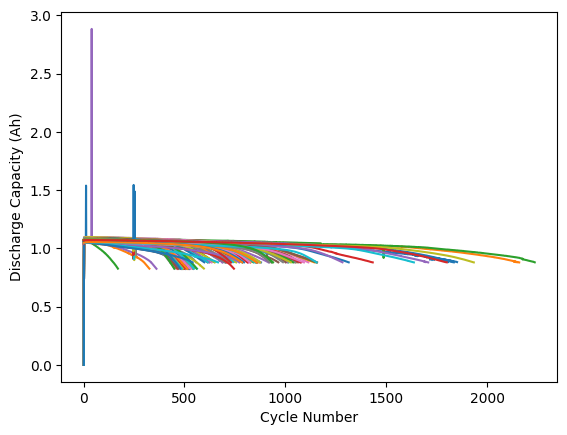

In [13]:
for i in bat_dict.keys():
    plt.plot(bat_dict[i]['summary']['cycle'], bat_dict[i]['summary']['QD'])
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')

In [14]:
#Train and test indices
test_ind = set(np.hstack((np.arange(0,(numBat1+numBat2),2),83)))
train_ind = set(np.arange(1,(numBat1+numBat2-1),2))
secondary_test_ind = set(np.arange(numBat-numBat3,numBat))

### KDD

In [15]:
# Summary data: IR - Battery internal resistance
#           QC - Charge capacity (Ah)
#           QD - Discharge capacity (Ah)
#           Tavg - Average Temperature in a given cycle(°C)
#           Tmin - Min Temperature in a given cycle(°C)
#           Tmax - Max Temperature in a given cycle(°C)
#           chargetime - Charge time in a given cycle
#           cycle - All cycles enumerated
batch1['b1c0']['summary'].keys()

dict_keys(['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime', 'cycle'])

In [16]:
# Cycle data: I - Current (A) 
#             t - Time
#             T - Temperature
#             V - Voltage (V)
#             Qc - Charge capacity (Ah)
#             Qd - Discharge capacity (Ah)
#             Qdlin - Linearly interpolated discharge capacity
#             dQdV - Derived vectors of discharge
#             Tdlin - Linearly interpolated temperature
batch1['b1c0']['cycles']['0'].keys()

dict_keys(['I', 'Qc', 'Qd', 'Qdlin', 'T', 'Tdlin', 'V', 'dQdV', 't'])

In [17]:
# Creating linear interpolated Voltage feature Vlin with 1000 points
for i in bat_dict.keys():
    for j in bat_dict[i]['cycles'].keys():
        cycle_data = bat_dict[i]['cycles'][j]
        
        interp_voltage = np.interp(np.linspace(0, 1, 1000), cycle_data['t'], cycle_data['V'])
        interp_time = np.linspace(cycle_data['t'].min(), cycle_data['t'].max(), 1000)
        bat_dict[i]['cycles'][j]['Vlin'] = interp_voltage
        bat_dict[i]['cycles'][j]['tlin'] = interp_time

In [18]:
# Creating the feature q100_10, that is the difference between the capacity discharge curve in cycle 100 and cycle 10
for i in bat_dict.keys():
    q10 = bat_dict[i]['cycles']['10']['Qdlin']
    q100 = bat_dict[i]['cycles']['100']['Qdlin']
    
    q100_10 = q100 - q10
    bat_dict[i]['summary']['q100_10'] = q100_10

Text(0.5, 0, 'Q100 - Q10 (Ah)')

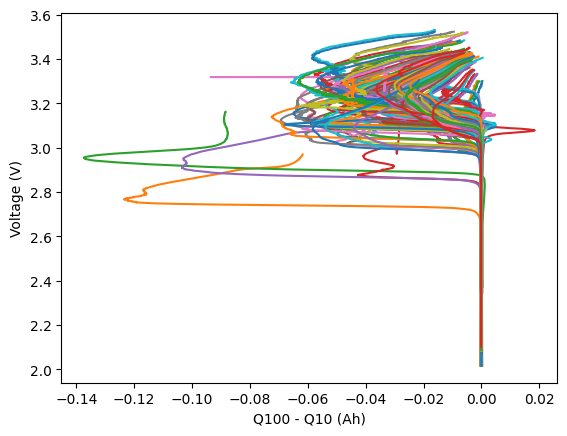

In [19]:
count = 0
for i in bat_dict.keys():
    if count >= 124:
        break
        
    voltage_curve = bat_dict[i]['cycles']['100']['Vlin']
    q100_10_curve = bat_dict[i]['summary']['q100_10']
    plt.plot(q100_10_curve, voltage_curve)

plt.ylabel('Voltage (V)')
plt.xlabel('Q100 - Q10 (Ah)')

In [20]:
train_dict = {}
test1_dict = {}
test2_dict = {}
count = 0

for i in bat_dict.keys():
    bat_data = bat_dict[i]
    
    if(count in train_ind):
        train_dict[i] = bat_data
    elif(count in test_ind):
        test1_dict[i] = bat_data
    else:
        test2_dict[i] = bat_data
    count += 1

## Aging prediction models

### Variance model

In [21]:
# Var of Q100 - Q10 is a important statistic with significant correlation with the cycle life
for i in bat_dict.keys():
    bat_dict[i]['summary']['q100_10_var'] = np.var(bat_dict[i]['summary']['q100_10'])

Pearson correlation coef Cycle Life x Var(Q100 - Q10) = PearsonRResult(statistic=-0.5414613800124808, pvalue=8.395588726613206e-11)


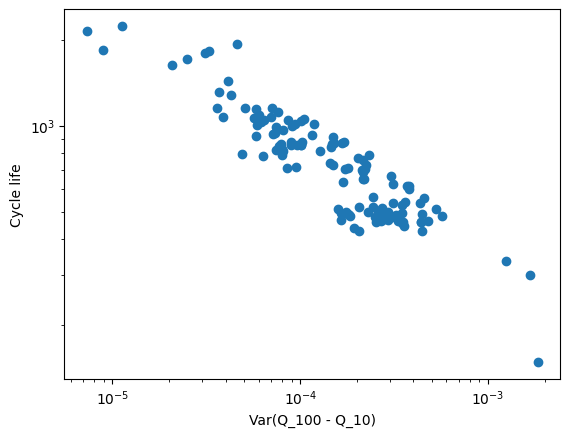

In [22]:
# Plot Cycle life x Var Q100 -  Q10
cycle_life_arr  = np.zeros(len(bat_dict.keys()))
q100_10_var_arr = np.zeros(len(bat_dict.keys()))
for i, bat in enumerate(bat_dict.keys()):
    cycle_life_arr[i]  = bat_dict[bat]['cycle_life']
    q100_10_var_arr[i] = bat_dict[bat]['summary']['q100_10_var']
    
plt.loglog(q100_10_var_arr, cycle_life_arr, marker = 'o', linestyle='None')
plt.ylabel('Cycle life')
plt.xlabel('Var(Q_100 - Q_10)')

corr = stats.pearsonr(cycle_life_arr, q100_10_var_arr)
print(f'Pearson correlation coef Cycle Life x Var(Q100 - Q10) = {corr}')

In [23]:
#Feature arr with only deltaQ Variance
X = np.zeros(len(train_dict.keys()))
# Target array with batteries cycle life
y = np.zeros(len(train_dict.keys()))

for i, bat in enumerate(train_dict.keys()):
    X[i] = train_dict[bat]['summary']['q100_10_var']
    y[i] = train_dict[bat]['cycle_life']

X = X.reshape(-1, 1)

In [24]:
alpha = [1e-6 ,1e-5, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
max_iter = [10000]
l1_ratio = np.arange(0.0, 1.0, 0.01)
tol = [0.5]

elasticnet_gscv = GridSearchCV(estimator=ElasticNet(), 
                                param_grid={'alpha': alpha,
                                            'max_iter': max_iter,
                                            'l1_ratio': l1_ratio,
                                            'tol':tol},   
                                scoring = 'r2',
                                cv=4)

In [25]:
elasticnet_gscv.fit(X, y)
elasticnet_gscv.best_params_

{'alpha': 1e-06, 'l1_ratio': 0.97, 'max_iter': 10000, 'tol': 0.5}

In [26]:
elasticnet = ElasticNet(alpha = elasticnet_gscv.best_params_['alpha'], 
                        max_iter = elasticnet_gscv.best_params_['max_iter'],
                        l1_ratio = elasticnet_gscv.best_params_['l1_ratio'],
                        )
elasticnet.fit(X, y)
print("Training set score: {:.2f}".format(elasticnet.score(X, y))) 

Training set score: 0.21


In [27]:
print(elasticnet_gscv.best_params_['alpha'])
print(elasticnet_gscv.best_params_['max_iter'])
print(elasticnet_gscv.best_params_['l1_ratio'])

1e-06
10000
0.97


In [28]:
pred = elasticnet.predict(X)
mpe = mean_absolute_percentage_error(y, pred)
mse = mean_squared_error(y, pred)
print(f'MPE = {mpe * 100}%')
print(f'RMSE = {np.sqrt(mse)}')

MPE = 27.401177397116523%
RMSE = 286.70997472261143


### Full model

In [29]:
# getFeatures function accepts the raw measurement data (battery dict) and computes the following features:
#
# Q_{100-10}(V) variance [q_100_10_var]
# Q_{100-10}(V) minimum [q_100_10_min]
# Slope of linear fit to the capacity fade curve cycles 2 to 100 [capFadeCycle2Slope]
# Intercept of linear fit to capacity fade curve, cycles 2 to 100 [capFadeCycle2Intercept]
# Discharge capacity at cycle 2 [qd2]
# Average charge time over first 5 cycles [avgChargeTime]
# Integral of temperature from cycles 2 to 100 [tempIntT]
# Minimum Internal Resistance, cycles 2 to 100 [minIR]
# Internal Resistance difference between cycles 2 and 100 [iRDiff2_100]
# 
def getFeatures(batch):
    for i in batch.keys():
        timeGapCycleList = []
        
        for cycle in batch[i]['cycles'].keys():
            if cycle == '0' or cycle == '1' or cycle == '100' or cycle == '10':
                continue
            # Compute cycles with time gaps  
            dt = np.diff(batch[i]['cycles'][cycle]['t'])
            if np.max(dt) > 5 * np.mean(dt):
                timeGapCycleList.append(cycle)
        # Delete cycles with time gaps
        for bad_cycle in timeGapCycleList:
            batch[i]['cycles'][bad_cycle] = []
            idx = int(bad_cycle)
            batch[i]['summary']['QD'][idx] = 0
            batch[i]['summary']['IR'][idx] = 0
            batch[i]['summary']['chargetime'][idx] = 0

        # Compute Q_100_10 stats
        DeltaQ = batch[i]['cycles']['100']['Qdlin'] - batch[i]['cycles']['10']['Qdlin']
        DeltaQ_var = np.log10(np.abs(np.var(DeltaQ)));
        DeltaQ_min = np.log10(np.abs(np.min(DeltaQ)));

        # Slope and intercept of linear fit for capacity fade curve from cycle 2 to cycle 100
        cycles = np.array(batch[i]['summary']['cycle'][2:101])
        Q_discharge = np.array(batch[i]['summary']['QD'][2:101]) 
        slope, intercept, _, _, _ = linregress(cycles, Q_discharge)
        capFadeCycle2Slope = slope
        capFadeCycle2Intercept = intercept

        # Discharge capacity at cycle 2
        qd2 = batch[i]['summary']['QD'][2]

        # Avg charge time, first 5 cycles (2 to 6)
        AvgChargeTime = np.mean(batch[i]['summary']['chargetime'][2:7]);
        
        # Integral of temperature from cycles 2 to 100
        tempIntT = 0
        for cycle in batch[i]['cycles'].keys():
            if cycle == 0 or cycle == 1:
                continue

            elif batch[i]['cycles'][cycle] == []:
                continue

            tempIntT = tempIntT + trapz(batch[i]['cycles'][cycle]['t'], batch[i]['cycles'][cycle]['T']);

        # Minimum internal resistance, cycles 2 to 100
        temp = batch[i]['summary']['IR'][2:101]
        minIR = np.min(temp[temp != 0])
        IRDiff2And100 = batch[i]['summary']['IR'][100] -  batch[i]['summary']['IR'][2]

        # Save features
        batch[i]['features'] = {}
        batch[i]['features']['deltaQ_var'] = DeltaQ_var
        batch[i]['features']['deltaQ_min'] = DeltaQ_min
        batch[i]['features']['capFadeCycle2Slope'] = capFadeCycle2Slope
        batch[i]['features']['capFadeCycle2Intercept'] = capFadeCycle2Intercept
        batch[i]['features']['qd2'] = qd2
        batch[i]['features']['avgChargeTime'] = AvgChargeTime
        batch[i]['features']['tempIntT'] = tempIntT
        batch[i]['features']['minIR'] = minIR 
        batch[i]['features']['IRDiff2And100'] = IRDiff2And100
        

In [30]:
# Compute features to all batches
getFeatures(train_dict)
getFeatures(test1_dict)
getFeatures(test2_dict)

In [31]:
columns = list(train_dict['b1c1']['features'].keys())
num_rows = len(train_dict.keys())
num_columns = len(columns)

# Creates the feature matrix
data = np.zeros((num_rows, num_columns))
for i, bat in enumerate(train_dict.keys()):
    for j, feature in enumerate(train_dict[bat]['features'].keys()):
        data[i, j] = train_dict[bat]['features'][feature]
        
# Creates dataframe
df = pd.DataFrame(data = data, columns = columns)

# Creates the cycle_life column
y = np.zeros(num_rows)
for i, bat in enumerate(train_dict.keys()):
    y[i] = train_dict[bat]['cycle_life']
df['cycle_life'] = y

In [32]:
df.head()

,deltaQ_var,deltaQ_min,capFadeCycle2Slope,capFadeCycle2Intercept,qd2,avgChargeTime,tempIntT,minIR,IRDiff2And100,cycle_life
0,-5.135776,-2.045150,0.000538,1.042365,1.076612,13.409131,12974.008706,0.016764,-0.000005,2160.0
1,-4.386348,-1.703321,0.000550,1.045442,1.081228,12.041925,5887.381665,0.016098,0.000098,1434.0
2,-4.155832,-1.583636,0.000527,1.042105,1.076653,10.950920,7107.838228,0.015923,-0.000083,1074.0
3,-3.821834,-1.428857,0.000519,1.058917,1.095110,10.042062,6406.787246,0.016083,0.000006,870.0
4,-4.099072,-1.598897,0.000544,1.021126,1.055032,11.685500,7859.723909,0.015963,-0.000312,788.0


In [33]:
# Define the X (feature) matrix and y (target) vector
X = df.drop(['cycle_life'], axis = 1)
y = df['cycle_life']

In [34]:
# Grid search for hiperparamter tunning
alpha = [1e-6 ,1e-5, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
max_iter = [10000]
l1_ratio = np.arange(0.0, 1.0, 0.01)
tol = [0.5]

elasticnet_gscv = GridSearchCV(estimator=ElasticNet(), 
                                param_grid={'alpha': alpha,
                                            'max_iter': max_iter,
                                            'l1_ratio': l1_ratio,
                                            'tol':tol},   
                                scoring = 'r2',
                                cv=4)

In [35]:
elasticnet_gscv.fit(X, y)
elasticnet_gscv.best_params_

{'alpha': 1, 'l1_ratio': 0.6900000000000001, 'max_iter': 10000, 'tol': 0.5}

In [36]:
elasticnet = ElasticNet(alpha = elasticnet_gscv.best_params_['alpha'], 
                        max_iter = elasticnet_gscv.best_params_['max_iter'],
                        l1_ratio = elasticnet_gscv.best_params_['l1_ratio'],)
elasticnet.fit(X, y)
print("Training set score: {:.2f}".format(elasticnet.score(X, y))) 

Training set score: 0.72


In [37]:
# Training metrics
pred = elasticnet.predict(X)
mpe = mean_absolute_percentage_error(y, pred)
mse = mean_squared_error(y, pred)
print(f'MPE = {mpe * 100}%')
print(f'RMSE = {np.sqrt(mse)}')

MPE = 14.25380439843196%
RMSE = 171.07517836982495


In [38]:
# Creates an empty matrix to save features
num_rows = len(test1_dict.keys())

# Creates the test1 feature matrix
data = np.zeros((num_rows, num_columns))
for i, bat in enumerate(test1_dict.keys()):
    for j, feature in enumerate(test1_dict[bat]['features'].keys()):
        data[i, j] = test1_dict[bat]['features'][feature]
        
# Creates test1 dataframe
test1_df = pd.DataFrame(data = data, columns = columns)

# Creates the test1 cycle_life column
y_test1 = np.zeros(num_rows)
for i, bat in enumerate(test1_dict.keys()):
    y_test1[i] = test1_dict[bat]['cycle_life']
test1_df['cycle_life'] = y_test1

In [39]:
# Define the test1 X and y
X_test1 = test1_df.drop(['cycle_life'], axis = 1)
y_test1 = test1_df['cycle_life']

In [40]:
# Test1 metrics
pred = elasticnet.predict(X_test1)
mpe = mean_absolute_percentage_error(y_test1, pred)
mse = mean_squared_error(y_test1, pred)
print(f'MPE = {mpe * 100}%')
print(f'RMSE = {np.sqrt(mse)}')

MPE = 21.930985339585977%
RMSE = 306.78267276030516


In [41]:
# Creates an empty matrix to save features
num_rows = len(test2_dict.keys())

# Creates the test1 feature matrix
data = np.zeros((num_rows, num_columns))
for i, bat in enumerate(test2_dict.keys()):
    for j, feature in enumerate(test2_dict[bat]['features'].keys()):
        data[i, j] = test2_dict[bat]['features'][feature]
        
# Creates test1 dataframe
test2_df = pd.DataFrame(data = data, columns = columns)

# Creates the test1 cycle_life column
y_test2 = np.zeros(num_rows)
for i, bat in enumerate(test2_dict.keys()):
    y_test2[i] = test2_dict[bat]['cycle_life']
test2_df['cycle_life'] = y_test2

In [42]:
# Define the test2 X and y
X_test2 = test2_df.drop(['cycle_life'], axis = 1)
y_test2 = test2_df['cycle_life']

In [43]:
# Test2 metrics
pred = elasticnet.predict(X_test2)
mpe = mean_absolute_percentage_error(y_test2, pred)
mse = mean_squared_error(y_test2, pred)
print(f'MPE = {mpe * 100}%')
print(f'RMSE = {np.sqrt(mse)}')

MPE = 18.259110958713425%
RMSE = 274.2624769826639
